In [1]:
import numpy as np
import sys
sys.path.insert(1, 'C:/Users/User/Code/DyGraph')

import DyGraph.DGlasso as dg
import matplotlib.pyplot as plt

In [2]:
prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

prec_2 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.0],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.0,  0.        , -0.60606061,  1.51515152]])

             

In [3]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    
from sklearn.covariance import GraphicalLasso
cov = GraphicalLasso(alpha = 0.01).fit(X[:1000])
cov.precision_

array([[ 1.42127762,  0.        , -0.90623727,  0.46440798],
       [ 0.        ,  2.49282609,  0.        , -0.        ],
       [-0.90623727,  0.        ,  4.12833303, -0.47167229],
       [ 0.46440798, -0.        , -0.47167229,  1.44997967]])

Test

(0.0, 25.0)

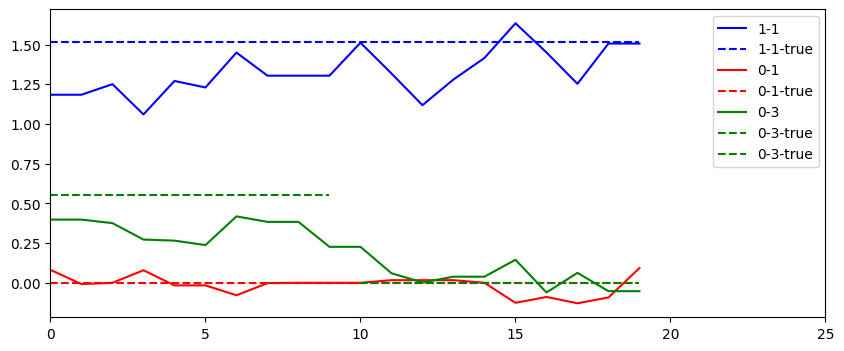

In [23]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

dg_opt = dg.DGlasso(obs_per_graph = 100, max_iter = 100, lamda = 0.01, kappa = 0.1, tol = 1e-6)
dg_opt.fit(X,'element-wise')
dg_opt.iteration
fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot([0, dg_opt.nr_graphs-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,1], label = "0-1", color = 'red')
ax.plot([0, dg_opt.nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,3], label = "0-3", color = 'green')
ax.plot([0, dg_opt.nr_graphs/2-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([dg_opt.nr_graphs/2, dg_opt.nr_graphs-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()
ax.set_xlim([0, dg_opt.nr_graphs+5])

(0.0, 25.0)

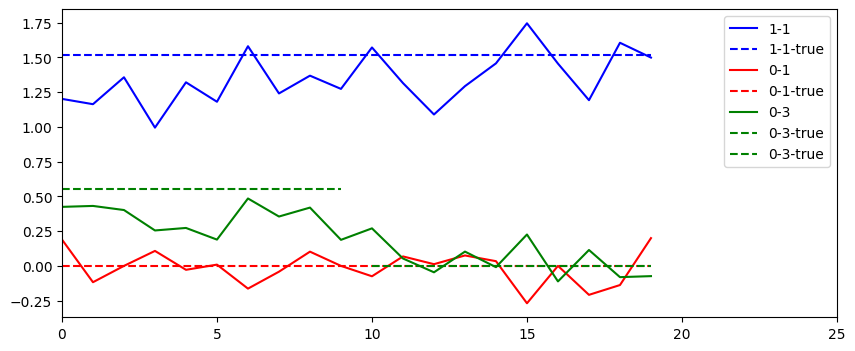

In [24]:
dg_opt = dg.DGlasso(obs_per_graph = 100, max_iter = 100, lamda = 0.01, kappa = 0, tol = 1e-6)
dg_opt.fit(X,'element-wise')
dg_opt.iteration
fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot([0, dg_opt.nr_graphs-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,1], label = "0-1", color = 'red')
ax.plot([0, dg_opt.nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(range(dg_opt.nr_graphs),dg_opt.theta[:,0,3], label = "0-3", color = 'green')
ax.plot([0, dg_opt.nr_graphs/2-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([dg_opt.nr_graphs/2, dg_opt.nr_graphs-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()
ax.set_xlim([0, dg_opt.nr_graphs+5])

In [25]:
def theta_update(theta,i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho):
    """
    Theta update

    Parameters
    ----------------
    i: int,
        index of being updates
    """
    k = i*obs_per_graph+obs_per_graph
    A = (z0[i]+z1[i]+z2[i] -  u0[i]-u1[i]-u2[i])/3.0
    AT = A.T
    S_i = np.einsum( 'ij,ik->jk',X[(k-obs_per_graph):k],X[(k-obs_per_graph):k])
    eta = obs_per_graph/3/rho
    M =  0.5*eta*(A+AT) - S_i
    D, Q = np.linalg.eig(M)
    diag_m = np.diag(D+np.sqrt(D**2 + 4/eta))
    return 0.5*eta*np.dot(Q, diag_m).dot(Q.T)


def theta_update_single(theta,i,obs_per_graph,z0,u0, rho, emp_cov):
    """
    Theta update

    Parameters
    ----------------
    i: int,
        index of being updates
    """
    A = z0[i] - u0[i]
    AT = A.T
    #S_i = np.einsum( 'ij,ik->jk',X[(k-obs_per_graph):k],X[(k-obs_per_graph):k])
    eta = obs_per_graph/rho
    M =  0.5*eta*(A+AT) - emp_cov[i]
    D, Q = np.linalg.eig(M)
    diag_m = np.diag(D+np.sqrt(D**2 + 4/eta))
    return np.real(0.5*eta*np.dot(Q, diag_m).dot(Q.T))

def theta_update_mult(i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho, emp_cov, nr_graphs):
    """
    Theta update

    Parameters
    ----------------
    i: int,
        index of being updates
    """
    if i == 0 or i == nr_graphs-1:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/2.0
    else:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/3.0
    AT = A.T
    eta = obs_per_graph/rho
    M =  0.5*eta*(A+AT) - emp_cov[i]
    D, Q = np.linalg.eig(M)
    diag_m = np.diag(D+np.sqrt(D**2 + 4/eta))
    return np.real(0.5*eta*np.dot(Q, diag_m).dot(Q.T))

def my_soft_threshold_odd(  A, lamda):

    """
    Off-diagonal lasso penalty

    Parameters
    ------------------
    A: np.array,
    
    lamda: float,
        regularization
    """
    opt_m = (A-lamda)*(A>=lamda) + (A+lamda)*(A<=-lamda)
    
    

    return opt_m

[[ 1.18 -0.01 -0.61  0.4 ]
 [-0.01  2.41 -0.27 -0.13]
 [-0.61 -0.27  3.14 -0.56]
 [ 0.4  -0.13 -0.56  1.4 ]]
[[ 1.52  0.   -1.06  0.55]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.55  0.   -0.61  1.52]]
  
[[ 1.51 -0.09 -0.71 -0.05]
 [-0.09  2.43 -0.07 -0.09]
 [-0.71 -0.07  3.22 -0.38]
 [-0.05 -0.09 -0.38  1.29]]
[[ 1.52  0.   -1.06  0.  ]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.    0.   -0.61  1.52]]


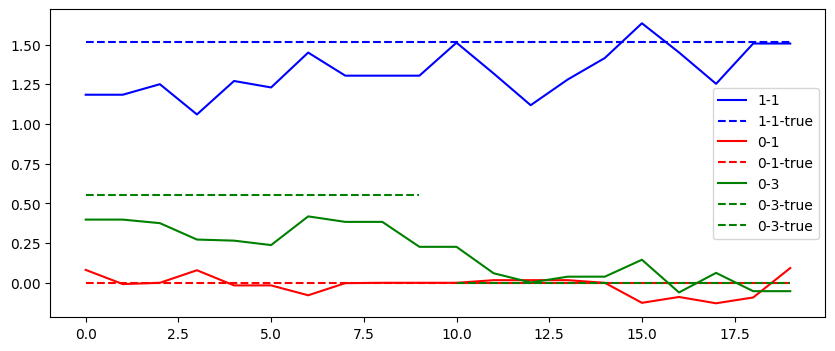

In [26]:
# n = 1000
# X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
# X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
# X = np.vstack((X1,X2))
# X = X1
emp_cov = []

obs_per_graph = 100
nr_graphs = int(X.shape[0]/obs_per_graph)
# unit test

for i in range(0, X.shape[0], obs_per_graph):
    emp_cov.append( np.cov(X[i:(i+obs_per_graph)].T)) 

rho = float(obs_per_graph+1)
lamda = 0.01
kappa = 0.1

iteration = 0
#assert nr_graphs >1, "X.shape[0]/obs_per_graph has to be at least 2 "
thetas_pre = np.zeros((nr_graphs, X.shape[1],X.shape[1]))

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

theta = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

for _ in range(100):
    # update theta
    for i in range(nr_graphs):
        theta[i] = theta_update_mult(i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho,emp_cov, nr_graphs)

    for i in range(nr_graphs):
        z0[i] = my_soft_threshold_odd(theta[i]+u0[i], lamda)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    for i in range(1,nr_graphs):
        E = my_soft_threshold_odd(theta[i]-theta[i-1]+u2[i]-u1[i-1], kappa)
        summ = 0.5*(theta[i]+theta[i-1]+u1[i-1]+u2[i])
        z1[i-1] = summ - 0.5*E
        z2[i] = summ + 0.5*E

    u0 = u0 + theta-z0
    u1[:(nr_graphs-1)] = u1[:(nr_graphs-1)] + theta[:(nr_graphs-1)]-z1[:(nr_graphs-1)]
    u2[1:] = u2[1:] + theta[1:] - z2[1:]

print(np.round(theta[1],2))
print(np.round(prec_1,2))
print("  ")
print(np.round(theta[-2],2))
print(np.round(prec_2,2))


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(range(nr_graphs),theta[:,0,0], label = "1-1", color = 'blue')
ax.plot([0, nr_graphs-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(range(nr_graphs),theta[:,0,1], label = "0-1", color = 'red')
ax.plot([0, nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(range(nr_graphs),theta[:,0,3], label = "0-3", color = 'green')
ax.plot([0, 9], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([10, 19], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


Single graph

In [73]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
#X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
#X = np.vstack((X1,X2))
X = X1
emp_cov = []
emp_cov.append( np.cov(X.T))

obs_per_graph =n
rho = obs_per_graph
lamda = 0.05

iteration = 0
nr_graphs = 1# int(X.shape[0]/obs_per_graph)
#assert nr_graphs >1, "X.shape[0]/obs_per_graph has to be at least 2 "
thetas_pre = np.zeros((nr_graphs, X.shape[1],X.shape[1]))

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
#z1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

theta = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

for _ in range(1000):
    # update theta
    for i in range(nr_graphs):
        theta[i] = theta_update_single(theta,i,obs_per_graph,z0,u0, rho,emp_cov)

    for i in range(nr_graphs):
        z0[i] = my_soft_threshold_odd(theta[i]+u0[i], lamda)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    u0 = u0 + theta-z0

print(np.round(theta,2))
print(np.round(prec_1,2))

[[[ 1.38  0.   -0.58  0.35]
  [ 0.    2.63 -0.    0.  ]
  [-0.58 -0.    3.6  -0.25]
  [ 0.35  0.   -0.25  1.35]]]
[[ 1.52  0.   -1.06  0.55]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.55  0.   -0.61  1.52]]


Break into blocks no temporal penalty

In [279]:
X[i:(i+obs_per_graph)].shape

(100, 4)

In [420]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
#X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
#X = np.vstack((X1,X2))
X = X1
emp_cov = []

obs_per_graph = 100
nr_graphs = int(n/obs_per_graph)
# unit test

for i in range(0, n, obs_per_graph):
    emp_cov.append( np.cov(X[i:(i+obs_per_graph)].T)) 

rho = obs_per_graph
lamda = 0.02

iteration = 0
#assert nr_graphs >1, "X.shape[0]/obs_per_graph has to be at least 2 "
thetas_pre = np.zeros((nr_graphs, X.shape[1],X.shape[1]))

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
#z1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
#z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

theta = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

for _ in range(100):
    # update theta
    for i in range(nr_graphs):
        theta[i] = theta_update_single(theta,i,obs_per_graph,z0,u0, rho,emp_cov)

    for i in range(nr_graphs):
        z0[i] = my_soft_threshold_odd(theta[i]+u0[i], lamda)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    u0 = u0 + theta-z0

print(np.round(theta[0],2))
print(np.round(prec_1,2))

[[ 1.88  0.   -1.02  0.33]
 [ 0.    2.38  0.    0.13]
 [-1.02  0.    3.96 -0.  ]
 [ 0.33  0.13 -0.    1.57]]
[[ 1.52  0.   -1.06  0.55]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.55  0.   -0.61  1.52]]


With dynamic

[[ 1.27  0.01 -0.68  0.57]
 [ 0.01  2.33  0.    0.  ]
 [-0.68  0.    3.05 -0.2 ]
 [ 0.57  0.   -0.2   1.56]]
[[ 1.52  0.   -1.06  0.55]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.55  0.   -0.61  1.52]]
  
[[ 1.36 -0.   -0.68 -0.03]
 [-0.    2.19 -0.   -0.03]
 [-0.68 -0.    3.06 -0.39]
 [-0.03 -0.03 -0.39  1.39]]
[[ 1.52  0.   -1.06  0.  ]
 [ 0.    2.5   0.    0.  ]
 [-1.06  0.    4.24 -0.61]
 [ 0.    0.   -0.61  1.52]]


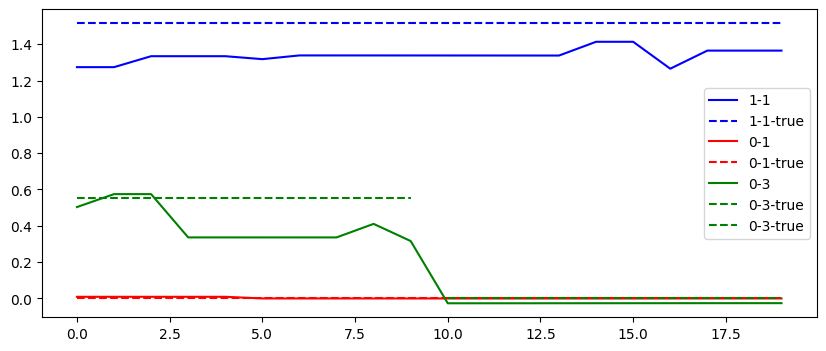

In [70]:
# n = 1000
# X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
# X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
# X = np.vstack((X1,X2))
# X = X1
emp_cov = []

obs_per_graph = 100
nr_graphs = int(X.shape[0]/obs_per_graph)
# unit test

for i in range(0, X.shape[0], obs_per_graph):
    emp_cov.append( np.cov(X[i:(i+obs_per_graph)].T)) 

rho = obs_per_graph+1
lamda = 0.03
kappa = 0.5

iteration = 0
#assert nr_graphs >1, "X.shape[0]/obs_per_graph has to be at least 2 "
thetas_pre = np.zeros((nr_graphs, X.shape[1],X.shape[1]))

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

theta = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

for _ in range(100):
    # update theta
    for i in range(nr_graphs):
        theta[i] = theta_update_mult(i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho,emp_cov, nr_graphs)

    for i in range(nr_graphs):
        z0[i] = my_soft_threshold_odd(theta[i]+u0[i], lamda)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    for i in range(1,nr_graphs):
        E = my_soft_threshold_odd(theta[i]-theta[i-1]+u2[i]-u1[i-1], kappa)
        summ = 0.5*(theta[i]+theta[i-1]+u1[i-1]+u2[i])
        z1[i-1] = summ - 0.5*E
        z2[i] = summ + 0.5*E

    u0 = u0 + theta-z0
    u1[:(nr_graphs-1)] = u1[:(nr_graphs-1)] + theta[:(nr_graphs-1)]-z1[:(nr_graphs-1)]
    u2[1:] = u2[1:] + theta[1:] - z2[1:]

print(np.round(theta[1],2))
print(np.round(prec_1,2))
print("  ")
print(np.round(theta[-2],2))
print(np.round(prec_2,2))


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(range(nr_graphs),theta[:,0,0], label = "1-1", color = 'blue')
ax.plot([0, nr_graphs-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(range(nr_graphs),theta[:,0,1], label = "0-1", color = 'red')
ax.plot([0, nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(range(nr_graphs),theta[:,0,3], label = "0-3", color = 'green')
ax.plot([0, 9], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([10, 19], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


Multiple

In [429]:
obs_per_graph =1
rho = 1
lamda = 0.01

iteration = 0
nr_graphs = int(X.shape[0]/obs_per_graph)
assert nr_graphs >1, "X.shape[0]/obs_per_graph has to be at least 2 "
thetas_pre = np.zeros((nr_graphs, X.shape[1],X.shape[1]))

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z1 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z2 = np.ones((nr_graphs, X.shape[1], X.shape[1]))

theta = np.zeros((nr_graphs, X.shape[1], X.shape[1]))


# update theta
for i in range(nr_graphs):
    theta[i] = theta_update(theta,i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho)

for i in range(nr_graphs):
    z0[i] = soft_threshold_odd(theta[i]+u0[i], lamda)
    np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))


C:\Users\User\AppData\Local\Temp\ipykernel_5744\101057560.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  theta[i] = theta_update(theta,i,obs_per_graph,z0,z1,z2,u0,u1,u2, rho)


NameError: name 'soft_threshold_odd' is not defined

In [154]:
theta_update(theta,26,obs_per_graph,z0,z1,z2,u0,u1,u2, rho)

array([[ 0.54267713,  0.02376797,  0.03818818,  0.06950447],
       [ 0.02376797,  0.56289915, -0.00852237, -0.01338695],
       [ 0.03818818, -0.00852237,  0.59991651, -0.05265664],
       [ 0.06950447, -0.01338695, -0.05265664,  0.54246537]])

In [121]:
theta[2]

array([[ 1.02303248, -0.09997863, -0.5474367 ,  0.2492735 ],
       [-0.09997863,  0.0285683 ,  0.15642679, -0.04426051],
       [-0.5474367 ,  0.15642679,  0.85652071, -0.24235007],
       [ 0.2492735 , -0.04426051, -0.24235007,  0.21857828]])

In [61]:
A = z0[i]+z1[i]+z2[i] -  u0[i]-u1[i]-u2[i]
AT = A.T
S_i = np.einsum( 'ij,ik->jk',X[(i-obs_per_graph):i],X[(i-obs_per_graph):i])
eta = obs_per_graph/3/rho
M =  0.5*eta*(A+AT) - S_i
D, Q = np.linalg.eig(M)

In [69]:
D+np.sqrt(D**2 + 4/eta)

array([3.46410162, 3.27099294, 3.46410162, 3.46410162])

Code frin tvgl

In [472]:
import time

def soft_threshold_odd(a, lambd, rho):

    # The off-diagonal Lasso penalty function.
    # Computes the Z0 update with off-diagonal
    # soft-threshold operator

    parameter = lambd/rho
    dimension = np.shape(a)[0]
    e = np.eye(dimension)
    for i in range(dimension - 1):
        for j in range(i + 1, dimension):
            if abs(a[i, j]) > parameter:
                result = np.sign(a[i, j])*(
                    abs(a[i, j]) - parameter)
                e[i, j] = result
                e[j, i] = result
    return e

class SingleGL():

    # Child class of BaseGraphicalLasso class.
    # computes a single Graphical Lasso problem
    # for the whole data set

    def __init__(self, obs, blocks, lambd, beta):
        self.obs = obs
        self.blocks = blocks
        self.dimension = 4
        self.emp_cov_mat = [0] * self.blocks
        self.real_thetas = [0] * self.blocks
        self.rho = self.get_rho()
        self.max_step = 0.1
        self.lambd = lambd
        self.beta = beta
        self.thetas = [np.ones((self.dimension, self.dimension))] * self.blocks
        self.z0s = [np.ones((self.dimension, self.dimension))] * self.blocks
        self.z1s = [np.ones((self.dimension, self.dimension))] * self.blocks
        self.z2s = [np.ones((self.dimension, self.dimension))] * self.blocks
        self.u0s = [np.zeros((self.dimension, self.dimension))] * self.blocks
        self.u1s = [np.zeros((self.dimension, self.dimension))] * self.blocks
        self.u2s = [np.zeros((self.dimension, self.dimension))] * self.blocks
        self.eta = float(self.obs)/float(3*self.rho)
        self.e = 1e-5
        self.roundup = 1
        self.nju = float(self.obs)/float(self.rho)
        self.iteration = "n/a"
        self.penalty_function = "n/a"
        self.e = 1e-7

    def get_rho(self):
        return self.obs + 1

    def run_algorithm(self, emp_cov, max_iter=10000):
        self.emp_cov_mat = emp_cov


        # self.init_algorithm()
        self.iteration = 0
        stopping_criteria = False
        thetas_pre = []
        start_time = time.time()
        while self.iteration < max_iter and stopping_criteria is False:
            if self.iteration % 500 == 0 or self.iteration == 1:
                print("\n*** Iteration %s ***" % self.iteration)
                print( "Time passed: {0:.3g}s".format(time.time() - start_time))
                print( "Rho: %s" % self.rho)
                print( "Eta: %s" % self.eta)
                print( "Step: {0:.3f}".format(1/(2*self.eta)))
            if self.iteration % 500 == 0 or self.iteration == 1:
                s_time = time.time()
            self.theta_update()
            if self.iteration % 500 == 0 or self.iteration == 1:
                print("Theta update: {0:.3g}s".format(time.time() - s_time))
            if self.iteration % 500 == 0 or self.iteration == 1:
                s_time = time.time()
            self.z_update()
            if self.iteration % 500 == 0 or self.iteration == 1:
                print( "Z-update: {0:.3g}s".format(time.time() - s_time))
            if self.iteration % 500 == 0 or self.iteration == 1:
                s_time = time.time()
            self.u_update()
            if self.iteration % 500 == 0 or self.iteration == 1:
                print( "U-update: {0:.3g}s".format(time.time() - s_time))
            """ Check stopping criteria """
            if self.iteration % 500 == 0 or self.iteration == 1:
                s_time = time.time()
            print(self.thetas)
            if self.iteration > 0:
                self.fro_norm = 0
                for i in range(self.blocks):
                    dif = self.thetas[i] - thetas_pre[i]
                    self.fro_norm += np.linalg.norm(dif)
                if self.fro_norm < self.e:
                    stopping_criteria = True
            thetas_pre = list(self.thetas)
            self.iteration += 1



    def theta_update(self):
        a = self.z0s[0] - self.u0s[0]
        at = a.transpose()
        m = self.nju*(a + at)/2 - self.emp_cov_mat[0]
        d, q = np.linalg.eig(m)
        qt = q.transpose()
        sqrt_matrix = np.sqrt(d**2 + 4/self.nju*np.ones(self.dimension))
        diagonal = np.diag(d) + np.diag(sqrt_matrix)
        self.thetas[0] = np.real(
            self.nju/2*np.dot(np.dot(q, diagonal), qt))

    def z_update(self):
        self.z0s[0] = soft_threshold_odd(self.thetas[0] + self.u0s[0],
                                            self.lambd, self.rho)

    def u_update(self):
        self.u0s[0] = self.u0s[0] + self.thetas[0] - self.z0s[0]

    def temporal_deviations(self):
        self.deviations = ["n/a"]
        self.norm_deviations = ["n/a"]
        self.dev_ratio = "n/a"

    def correct_edges(self):
        self.real_edges = 0
        self.real_edgeless = 0
        self.correct_positives = 0
        self.all_positives = 0
        for real_network in self.real_thetas:
            for i in range(self.dimension - 1):
                for j in range(i + 1, self.dimension):
                    if real_network[i, j] != 0:
                        self.real_edges += 1
                        if self.thetas[0][i, j] != 0:
                            self.correct_positives += 1
                            self.all_positives += 1
                    elif real_network[i, j] == 0:
                        self.real_edgeless += 1
                        if self.thetas[0][i, j] != 0:
                            self.all_positives += 1
        self.precision = float(self.correct_positives)/float(
            self.all_positives)
        self.recall = float(self.correct_positives)/float(
            self.real_edges)
        self.f1score = 2*(self.precision*self.recall)/float(
            self.precision + self.recall)

In [444]:
emp_cov = []
for i in range(5):

    S_i = np.einsum( 'ij,ik->jk',X[(i-1):i],X[(i-1):i])
    emp_cov.append(S_i)

In [473]:
sg = SingleGL(obs = 1,blocks = 1, lambd = 0.001, beta = 0.1)
sg.run_algorithm(emp_cov,100)


*** Iteration 0 ***
Time passed: 0s
Rho: 2
Eta: 0.16666666666666666
Step: 3.000
Theta update: 0.00104s
Z-update: 0s
U-update: 0s
[array([[0.87183644, 0.16472966, 0.16472966, 0.16472966],
       [0.16472966, 0.87183644, 0.16472966, 0.16472966],
       [0.16472966, 0.16472966, 0.87183644, 0.16472966],
       [0.16472966, 0.16472966, 0.16472966, 0.87183644]])]

*** Iteration 1 ***
Time passed: 0.00104s
Rho: 2
Eta: 0.16666666666666666
Step: 3.000
Theta update: 0s
Z-update: 0s
U-update: 0s
[array([[ 0.94612996,  0.2094737 ,  0.01402891, -0.2317045 ],
       [ 0.2094737 ,  0.8933161 ,  0.08570559, -0.25056732],
       [ 0.01402891,  0.08570559,  0.51503388,  0.32315969],
       [-0.2317045 , -0.25056732,  0.32315969,  1.09704019]])]
[array([[ 0.87112953,  0.03217571,  0.00152049, -0.03477524],
       [ 0.03217571,  0.8792774 ,  0.01245536, -0.03744086],
       [ 0.00152049,  0.01245536,  0.93806487,  0.04922556],
       [-0.03477524, -0.03744086,  0.04922556,  0.84991879]])]
[array([[ 8.897

In [471]:
sg.fro_norm


8.998305257330678e-08